# 何をするのか
Vtuberのハッシュタグを検索し、ツイート内容をCharacter-Level CNNにかけて分類器を作ります。  
ハッシュタグのないツイートがどんな話題についてのものなのか予測することができる機能を期待しています。  
目的としてはTwitterAPIに慣れたい＆自然言語処理っぽいことしたい＆Kerasを実装してみたい、といったところです。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


スクレイピングのコードはこちら→https://github.com/Kiro02/TweetClasifier/blob/master/searcher.py

In [2]:
df_1 = pd.read_csv("キズナアイ.csv")
df_2 = pd.read_csv("輝夜月.csv")
df_3 = pd.read_csv("バーチャルのじゃロリ狐娘Youtuberおじさん.csv")
df_4 = pd.read_csv("ミライアカリ.csv")
df_5 = pd.read_csv("月ノ美兎.csv")

In [3]:
df = pd.concat([df_1,df_2,df_3,df_4,df_5])
df = df.reset_index()

In [4]:
del df["Unnamed: 0"] #よくわからない列ができてしまったので消す

In [5]:
df.head()

,index,hashtag,text
0,0,キズナアイ,#キズナアイ\nこれは前にアニメイト行った時に買ったやつ✨✨一目惚れ(♥ω♥*)ｷｭﾝｷｭﾝ...
1,1,キズナアイ,遂にやっちゃったキズナアイ面接っっ😆✨すっごいテンポ早いんだね！！！とろちゃんはついていける...
2,2,キズナアイ,#キズナアイ\nこの前ガチャガチャやった時のやつ！\n本当にかわいい！💕 https://t...
3,3,キズナアイ,#丸勘パジャマでどこまで行けるか\n#丸勘うちわ\n#のんのんびより\n#のんのんびよりギャ...
4,4,キズナアイ,「両極端は、あい交わる」 #キズナアイ


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 3 columns):
index      434 non-null int64
hashtag    434 non-null object
text       434 non-null object
dtypes: int64(1), object(2)
memory usage: 10.2+ KB


・ツイートは最大１４０文字なのでそれを固定長にする（CNNなので可変長はNG)  
・ハッシュタグそのものは取り除く  
・データは生放送とかでワードに偏りが出てしまうので、いろいろな時期から撮りたい  
→サーバー上で定期的に動かすようにする  
・改行文字などを消去する  
・URLを除外  

In [7]:
#前処理はMeCabで。
import MeCab
m = MeCab.Tagger ("-Ochasen")
#テスト
print(m.parse(df.loc[2,["text"]][0]))

#	#	#	名詞-サ変接続		
キズナアイ	キズナアイ	キズナアイ	名詞-一般		
この	コノ	この	連体詞		
前	マエ	前	名詞-副詞可能		
ガチャガチャ	ガチャガチャ	ガチャガチャ	名詞-一般		
やっ	ヤッ	やる	動詞-自立	五段・ラ行	連用タ接続
た	タ	た	助動詞	特殊・タ	基本形
時	トキ	時	名詞-非自立-副詞可能		
の	ノ	の	助詞-連体化		
やつ	ヤツ	やつ	名詞-代名詞-一般		
！	！	！	記号-一般		
本当に	ホントウニ	本当に	副詞-一般		
かわいい	カワイイ	かわいい	形容詞-自立	形容詞・イ段	基本形
！	！	！	記号-一般		
💕	💕	💕	記号-一般		
https	https	https	名詞-固有名詞-組織		
://	://	://	名詞-サ変接続		
t	t	t	名詞-一般		
.	.	.	名詞-サ変接続		
co	co	co	名詞-一般		
/	/	/	名詞-サ変接続		
cmUnsIXl	cmUnsIXl	cmUnsIXl	名詞-一般		
1	1	1	名詞-数		
o	o	o	名詞-固有名詞-組織		
EOS



In [8]:
string="#キズナアイ\nこの前ガチャガチャやった時のやつ！\n本当にかわいい！"
string.replace("\n","")
string.strip()
print(string)

#キズナアイ
この前ガチャガチャやった時のやつ！
本当にかわいい！


In [9]:
test = [ord(x) for x in string.strip()] #文章をベクトル化
print(test)
print(len(string),len(test))

[35, 12461, 12474, 12490, 12450, 12452, 10, 12371, 12398, 21069, 12460, 12481, 12515, 12460, 12481, 12515, 12420, 12387, 12383, 26178, 12398, 12420, 12388, 65281, 10, 26412, 24403, 12395, 12363, 12431, 12356, 12356, 65281]
33 33


In [10]:
def replace_words(dataframe, word1, word2):
    """
    ツイート内のword1をword2置換
    """
    for i in range(len(dataframe.loc[:,["text"]])):
        dataframe.loc[i,["text"]] = dataframe.loc[i,["text"]].astype(str)[0].replace(str(word1),str(word2))
    return dataframe

In [11]:
df = replace_words(df, "\n", "") #改行記号削除
#ハッシュタグ削除
for vtuber in ["キズナアイ","輝夜月","ミライアカリ","バーチャルのじゃロリ狐娘Youtuberおじさん","月ノ美兎"]:
    df = replace_words(df, ("#" + vtuber), "")
df.tail()

,index,hashtag,text
429,95,月ノ美兎,#すーぱーそに子 まさかのコラボhttps://t.co/Mpw3WZsigw
430,96,月ノ美兎,すき https://t.co/WjyXWgOhzM
431,97,月ノ美兎,みとみとが真面目に話してるところに上から100トンがポンポン落ちてきてるの面白すぎる
432,98,月ノ美兎,月ノ美兎の放課後ラジオ #6 配信を開始しました #委員長すき #にじさんじ https:...
433,99,月ノ美兎,公式ﾗｲﾊﾞｰ情報まとめ9月9日更新https://t.co/WasJr6KzCJ#鈴谷アキ...


In [12]:
#ツイートの固定長ベクトル化
def string2vec(dataframe):
    array = np.arange(140).reshape(1,140)
    for i in range(len(dataframe.loc[:,["text"]])): #ベクトル化
        string_vec = [ord(x) for x in dataframe.loc[i,["text"]].astype(str)[0].strip()]
        while len(string_vec) < 140:     #140の長さで固定するためのゼロパディング
            string_vec.append(0)
        string_array = np.array(string_vec)
        string_array = string_array.reshape(1,140)
        array = np.append(array, string_array, axis=0)
    A = pd.DataFrame(array).iloc[1:,:].reset_index()
    dataframe = pd.concat([dataframe,A], axis=1)
    return dataframe

In [13]:
vec_df=string2vec(df)

In [14]:
vec_df.head()

,index,hashtag,text,index,0,1,2,3,4,5,...,130,131,132,133,134,135,136,137,138,139
0,0,キズナアイ,これは前にアニメイト行った時に買ったやつ✨✨一目惚れ(♥ω♥*)ｷｭﾝｷｭﾝ♡*゜ http...,1,12371,12428,12399,21069,12395,12450,...,0,0,0,0,0,0,0,0,0,0
1,1,キズナアイ,遂にやっちゃったキズナアイ面接っっ😆✨すっごいテンポ早いんだね！！！とろちゃんはついていける...,2,36930,12395,12420,12387,12385,12419,...,85,75,100,0,0,0,0,0,0,0
2,2,キズナアイ,この前ガチャガチャやった時のやつ！本当にかわいい！💕 https://t.co/cmUnsI...,3,12371,12398,21069,12460,12481,12515,...,0,0,0,0,0,0,0,0,0,0
3,3,キズナアイ,#丸勘パジャマでどこまで行けるか#丸勘うちわ#のんのんびより#のんのんびよりギャラリー#劇場...,4,35,20024,21208,12497,12472,12515,...,0,0,0,0,0,0,0,0,0,0
4,4,キズナアイ,「両極端は、あい交わる」,5,12300,20001,26997,31471,12399,12289,...,0,0,0,0,0,0,0,0,0,0


ツイートをベクトルにすることができた。次はCNNにかけていく。

In [15]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

#kerasではバックエンドでTensorFlowを回しているのでkeras使用時は毎回importする。
import tensorflow as tf
import keras

#層構造のモデルを定義するためのメソッド（kerasのモデル構築で必ず使う）
from keras.models import Sequential

# Denseは層の生成メソッド、Activationは活性化関数を定義するためのメソッド
#Flattenは二次元配列を一次元配列に変換する層
from keras.layers import Dense, Activation, Flatten

#SGD：ディープラーニングにおいて最も基本的な最適化手法
from keras.optimizers import SGD

In [16]:
vec_df.iloc[0,:].values

array([0, 'キズナアイ',
       'これは前にアニメイト行った時に買ったやつ✨✨一目惚れ(♥ω♥*)ｷｭﾝｷｭﾝ♡*゜ https://t.co/oFIduW79WY',
       1, 12371, 12428, 12399, 21069, 12395, 12450, 12491, 12513, 12452,
       12488, 34892, 12387, 12383, 26178, 12395, 36023, 12387, 12383,
       12420, 12388, 10024, 10024, 19968, 30446, 24794, 12428, 40, 9829,
       969, 9829, 42, 41, 65399, 65389, 65437, 65399, 65389, 65437, 9825,
       42, 12444, 32, 104, 116, 116, 112, 115, 58, 47, 47, 116, 46, 99,
       111, 47, 111, 70, 73, 100, 117, 87, 55, 57, 87, 89, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=object)

このままでは目的変数が文字列なのでone-hotエンコーディングでベクトルにする。

In [17]:
pd.get_dummies(vec_df['hashtag']).sample(frac=1).head()

,キズナアイ,バーチャルのじゃロリ狐娘Youtuberおじさん,ミライアカリ,月ノ美兎,輝夜月
43,1,0,0,0,0
193,0,1,0,0,0
18,1,0,0,0,0
133,0,0,0,0,1
287,0,0,1,0,0


In [18]:
y_train = pd.get_dummies(vec_df['hashtag']).values #学習用目的変数の作成

いい感じにベクトルにできてました。説明変数も作りましょう。

In [19]:
x_train = vec_df.iloc[:,4:].values #学習用説明変数の作成

In [20]:
#Kerasで扱えるようにfloatデータにします
x_train = x_train.astype("f")
y_train = y_train.astype("f")

In [21]:
print(y_train[1])
print(x_train[1])

[1. 0. 0. 0. 0.]
[3.69300e+04 1.23950e+04 1.24200e+04 1.23870e+04 1.23850e+04 1.24190e+04
 1.23870e+04 1.23830e+04 1.24610e+04 1.24740e+04 1.24900e+04 1.24500e+04
 1.24520e+04 3.87540e+04 2.55090e+04 1.23870e+04 1.23870e+04 1.28518e+05
 1.00240e+04 1.23770e+04 1.23870e+04 1.23720e+04 1.23560e+04 1.24860e+04
 1.25310e+04 1.25090e+04 2.60890e+04 1.23560e+04 1.24350e+04 1.23840e+04
 1.23970e+04 6.52810e+04 6.52810e+04 6.52810e+04 1.23920e+04 1.24290e+04
 1.23850e+04 1.24190e+04 1.24350e+04 1.23990e+04 1.23880e+04 1.23560e+04
 1.23900e+04 1.23560e+04 1.23690e+04 1.24270e+04 1.23980e+04 1.23910e+04
 1.23750e+04 1.24230e+04 1.23580e+04 1.23630e+04 8.23000e+03 8.26500e+03
 6.50380e+04 1.27800e+05 2.12050e+04 3.00110e+04 1.23990e+04 1.23710e+04
 1.23850e+04 1.24250e+04 1.27800e+05 1.04000e+02 1.16000e+02 1.16000e+02
 1.12000e+02 1.15000e+02 5.80000e+01 4.70000e+01 4.70000e+01 1.16000e+02
 4.60000e+01 9.90000e+01 1.11000e+02 4.70000e+01 1.05000e+02 1.18000e+02
 1.07000e+02 4.90000e+01 4.80000e+

In [60]:
#---------
#MLP-Model
#---------

model = Sequential()

model.add(Dense(500, input_shape=(140,)))
model.add(Dense(500))
model.add(Activation("relu"))

model.add(Dense(1000))
model.add(Activation("tanh"))

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(5))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])    

Relu関数のところでエラーになる・・・  
・・・なぜか第２層の活性化関数をハイパボリックタンジェントにしたらうまくいった（なぜ？）  
そしてよくよく考えたらtestデータがなかったので取ってくる（そしてまた同じ処理をする）

In [27]:
df_1_t = pd.read_csv("test_data/キズナアイ.csv")
df_2_t = pd.read_csv("test_data/輝夜月.csv")
df_3_t = pd.read_csv("test_data/バーチャルのじゃロリ狐娘Youtuberおじさん.csv")
df_4_t = pd.read_csv("test_data/ミライアカリ.csv")
df_5_t = pd.read_csv("test_data/月ノ美兎.csv")

In [28]:
df_t = pd.concat([df_1_t,df_2_t,df_3_t,df_4_t,df_5_t])
df_t = df_t.reset_index()

In [29]:
del df_t["Unnamed: 0"] #よくわからない列ができてしまったので消す

In [30]:
df_t.head()

,index,hashtag,text
0,0,キズナアイ,#キズナアイ 騒動の千田有紀。雇用している武蔵大学の学長ってどんな人かと思ってプロフィール見...
1,1,キズナアイ,死にゲーやるキズナアイはなぜこうも面白いのか\n#キズナアイ https://t.co/72...
2,2,キズナアイ,only the best #KizunaAI #キズナアイ https://t.co/cE...
3,3,キズナアイ,「I am Bread #5」のサムネイルが何故か城島リーダーのあの画像に見えたんだけど、自...
4,4,キズナアイ,さっきよくわかるキズナアイの動画見てきた。うん、こんなにもっと早く出会いたかったって思った人...


In [31]:
df_t = replace_words(df_t, "\n", "") #改行記号削除
#ハッシュタグ削除
for vtuber in ["キズナアイ","輝夜月","ミライアカリ","バーチャルのじゃロリ狐娘Youtuberおじさん","月ノ美兎"]:
    df_t = replace_words(df_t, ("#" + vtuber), "")
df_t.tail()

,index,hashtag,text
388,95,月ノ美兎,カスタムキャストで月ノ美兎委員長に似てる子作りました。制服とピッタリなニーソとヘラピンがない...
389,96,月ノ美兎,思い出さなくて良いから…(良心) https://t.co/dBxdPZxdO6
390,97,月ノ美兎,2分ちょっとで分かる月ノ美兎*1話#バーチャルYouTuber#Vtuberhttps://...
391,98,月ノ美兎,#にじさんじ https://t.co/Jv2mynE56Y
392,99,月ノ美兎,『楓の葉は きみと共に』https://t.co/J4jh1hoxcppixivにて投稿。月...


In [32]:
vec_df_t=string2vec(df_t)

In [33]:
y_test = pd.get_dummies(vec_df_t['hashtag']).values #検証用目的変数の作成

In [34]:
x_test = vec_df_t.iloc[:,4:].values #学習用説明変数の作成

In [35]:
#Kerasで扱えるようにfloatデータにします
x_test = x_test.astype("f")
y_test = y_test.astype("f")

前処理は一つの関数にまとめておきたいですね・・・  
いよいよ学習に入ります

In [ ]:
#実際に学習させる（注意：hist変数は学習終了後生成されるので中断したら参照できない）
hist = model.fit(x_train,
                 y_train,
                 epochs=6000,
                 validation_data=(x_test, y_test))= y_test.astype("f")

# 学習結果の確認
グラフとかを出力して、学習の結果を確認します。

In [64]:
# 学習精度をテストデータで確認できる（学習時にvalidation_dataとして入力していたら必要ない）
loss_and_metrics = model.evaluate(x_test, y_test)
loss_and_metrics #（損失値、精度）を返す

 32/393 [=>............................] - ETA: 0s

[2.710115054788177, 0.36132315567128226]

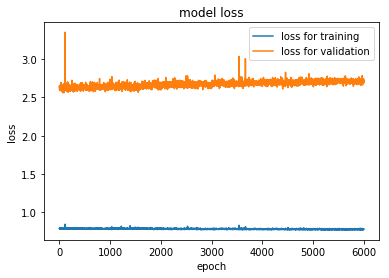

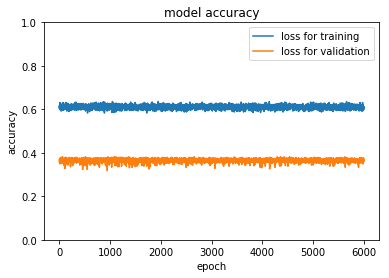

In [65]:
# プロットして損失値と精度の推移を視覚化するのは非常に重要な作業なので特に理由がなければ毎度表示する。
# 過学習や学習不足が確認できる。


# 損失値(Loss)の遷移のプロット
def plot_history_loss(hist):
    
    # hist.historyに辞書型で損失値や精度が入っているので取得して表示
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    
    #matplotlibの細かい設定
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    
    plt.show()

    
# 精度(Accuracy)の遷移のプロット
def plot_history_acc(hist):
    plt.plot(hist.history['acc'],label="loss for training")
    plt.plot(hist.history['val_acc'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

**全然ダメダメですね。**ダメな原因としては  
・流石にデータが少ない   
・前処理が雑すぎる。URL消すとか、他のハッシュタグを消すとか、ノイズっぽいツイートを消すなどしたい  
・データが少ないのにCNNにする必要性があまりない。普通にMeCabで形態素解析してランダムフォレストとか機械学習アルゴリズムにかけたほうが精度高そう  
・ツイート時期に偏りがあるツイート集合で学習・検証データを作ってしまったので混ぜたほうがよかったかもしれない  
・CNNの設計を考え直すのもいいかもしれない